In [1]:
import os

# Binary semantic segmentation
### by AIvanov

1) Reference paper BiSeNet https://arxiv.org/abs/1808.00897

2) Baseline training set https://drive.google.com/open?id=1MOTVekem9o6PyEaXnuzYuzq8HdzNpHnC

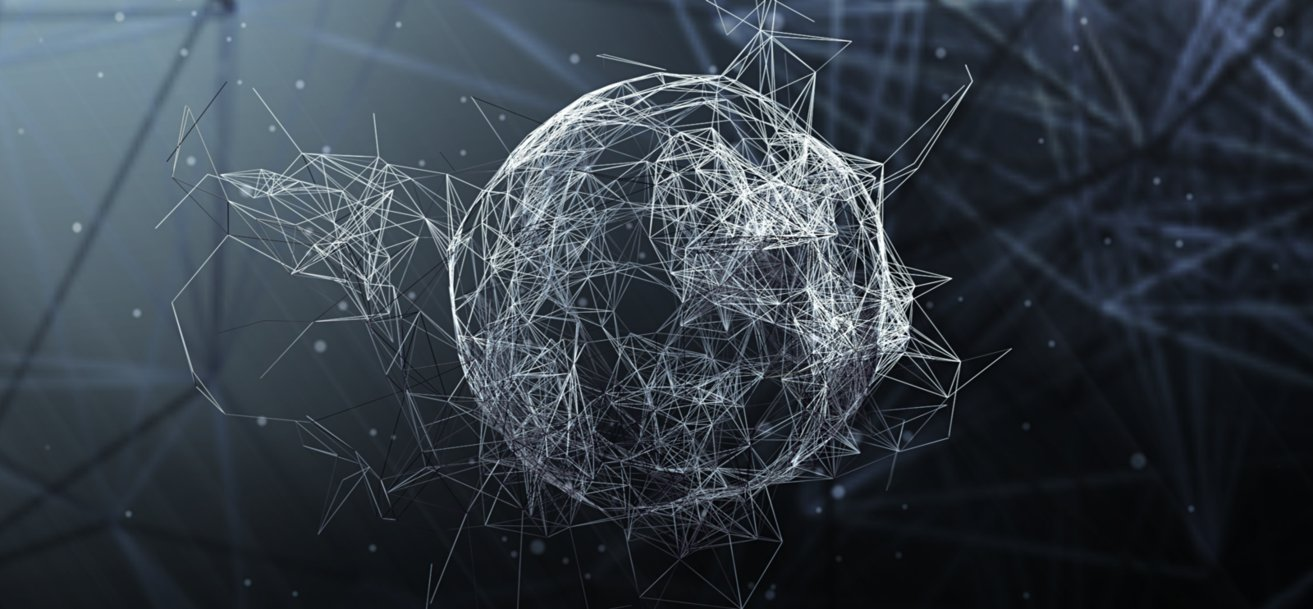

In [2]:
from IPython.display import Image
logo = Image(filename=os.path.join('.', 'logo.jpg'))
display(logo)

In [3]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import copy
from glob import glob
import torchvision.models as models
from torch.utils.data import Dataset
import cv2
from PIL import Image
import random
import torchvision.transforms
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from torchvision import transforms

%matplotlib inline

### fix the random's seed for reproducibility

In [4]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cv2.setRNGSeed(seed)

In [5]:
debug = False

### Датасеты для обучения и тестирования

In [6]:
from dataloaders import SimpleSemanticDataset

In [7]:
data_set_name = 'segmentation_data_set' #ellipse_database
test_set_name = 'test'
val_set_name = 'val'
train_set_name = 'train'

In [8]:
data_set_root = os.path.join('.', data_set_name)
test_set_path = os.path.join(data_set_root, test_set_name)
val_set_path = os.path.join(data_set_root, val_set_name)
train_set_path = os.path.join(data_set_root, train_set_name)

In [9]:
do_norm = False    
# Datasets
data_train = SimpleSemanticDataset(train_set_path, do_norm)
data_eval = SimpleSemanticDataset(val_set_path, do_norm)

In [10]:
train_len = len(data_train)
train_len

544

### Show 1% of training samples

In [ ]:
# Example images
for i in range(0, int(train_len * 0.01)):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(data_train[i][0].cpu().numpy().transpose(1, 2, 0))
    plt.subplot(1, 2, 2)
    _ = plt.imshow(data_train[i][1][0, :, :].cpu().numpy(), cmap='gray')

## BiSeNet implementation

In [12]:
from bisenet import BiSeNet
from bisenet import *

### Training and validation 

## Setup Hyperparameters

In [13]:
class_number = 2
LR = 0.001# Set desired learning rate
B_SIZE = 2# Set desired batch size
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epochs = 50
momentum = 0.9

### Dataloaders

In [14]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size=B_SIZE, 
                                           shuffle=True)
eval_loader = torch.utils.data.DataLoader(dataset=data_eval,
                                          batch_size=B_SIZE, 
                                          shuffle=False)

### Load model

In [15]:
model_dir = os.path.join('.', 'model')
if (not os.path.exists(model_dir)):
    os.mkdir(model_dir)
model_st_path = os.path.join('.', model_dir, 'state_bisenet_rs18.pth')
model_path = os.path.join('.', model_dir, 'bisenet_rs18.pth')
model = None

In [16]:
model = torch.load(model_path)
model.load_state_dict(torch.load(model_st_path))
model.eval()

BiSeNet(
  (context_path): ResNetEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [17]:
# Model definition
if model == None:
    model = BiSeNet(class_number).to(device)

In [18]:
debug = False

In [19]:
from bisenet_training import *

### Training

In [20]:
# Loss and optimizer
criterions = [nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss()]
if not momentum == None:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# Train
model, history = train(model, optimizer, train_loader, eval_loader, criterions, epochs, device, './logdir/resnet')

Epoch [1/50] | Loss (train/val): 0.6163/0.5174  | Acc (train/val): 0.1352/0.1347


Epoch [2/50] | Loss (train/val): 0.3766/0.4676  | Acc (train/val): 0.1341/0.1329


Epoch [3/50] | Loss (train/val): 0.3389/0.4877  | Acc (train/val): 0.1330/0.1323


Epoch [4/50] | Loss (train/val): 0.3153/0.4822  | Acc (train/val): 0.1329/0.1320


Epoch [5/50] | Loss (train/val): 0.2903/0.4871  | Acc (train/val): 0.1329/0.1317


Epoch [6/50] | Loss (train/val): 0.2702/0.5097  | Acc (train/val): 0.1329/0.1314


Epoch [7/50] | Loss (train/val): 0.2525/0.5271  | Acc (train/val): 0.1327/0.1312


Epoch [8/50] | Loss (train/val): 0.2355/0.5493  | Acc (train/val): 0.1329/0.1310


Epoch [9/50] | Loss (train/val): 0.2148/0.5740  | Acc (train/val): 0.1329/0.1309


Epoch [10/50] | Loss (train/val): 0.1979/0.6129  | Acc (train/val): 0.1331/0.1308


Epoch [11/50] | Loss (train/val): 0.1828/0.6381  | Acc (train/val): 0.1332/0.1308


Epoch [12/50] | Loss (train/val): 0.1697/0.6376  | Acc (train/val): 0.1333/0.1308


Epoch [13/50] | Loss (train/val): 0.1591/0.7063  | Acc (train/val): 0.1335/0.1308


Epoch [14/50] | Loss (train/val): 0.1496/0.7127  | Acc (train/val): 0.1335/0.1307


Epoch [15/50] | Loss (train/val): 0.1432/0.7442  | Acc (train/val): 0.1336/0.1306


Epoch [16/50] | Loss (train/val): 0.1369/0.7699  | Acc (train/val): 0.1338/0.1305


Epoch [17/50] | Loss (train/val): 0.1315/0.7892  | Acc (train/val): 0.1338/0.1304


Epoch [18/50] | Loss (train/val): 0.1261/0.8204  | Acc (train/val): 0.1339/0.1304


Epoch [19/50] | Loss (train/val): 0.1230/0.8326  | Acc (train/val): 0.1340/0.1303


Epoch [20/50] | Loss (train/val): 0.1180/0.8463  | Acc (train/val): 0.1341/0.1302


Epoch [21/50] | Loss (train/val): 0.1136/0.8745  | Acc (train/val): 0.1342/0.1303


Epoch [22/50] | Loss (train/val): 0.1103/0.8576  | Acc (train/val): 0.1342/0.1303


Epoch [23/50] | Loss (train/val): 0.1069/0.8546  | Acc (train/val): 0.1342/0.1302


Epoch [24/50] | Loss (train/val): 0.1043/0.8775  | Acc (train/val): 0.1343/0.1303


Epoch [25/50] | Loss (train/val): 0.1029/0.9735  | Acc (train/val): 0.1344/0.1303


Epoch [26/50] | Loss (train/val): 0.1007/0.9234  | Acc (train/val): 0.1344/0.1303


Epoch [27/50] | Loss (train/val): 0.0988/0.9032  | Acc (train/val): 0.1345/0.1303


Epoch [28/50] | Loss (train/val): 0.0957/0.9220  | Acc (train/val): 0.1345/0.1303


Epoch [29/50] | Loss (train/val): 0.0941/0.9501  | Acc (train/val): 0.1346/0.1302


Epoch [30/50] | Loss (train/val): 0.0925/0.9639  | Acc (train/val): 0.1346/0.1302


Epoch [31/50] | Loss (train/val): 0.0903/1.0054  | Acc (train/val): 0.1346/0.1301


Epoch [32/50] | Loss (train/val): 0.0888/1.0155  | Acc (train/val): 0.1347/0.1301


Epoch [33/50] | Loss (train/val): 0.0875/1.0006  | Acc (train/val): 0.1347/0.1301


Epoch [34/50] | Loss (train/val): 0.0861/0.9994  | Acc (train/val): 0.1347/0.1301


Epoch [35/50] | Loss (train/val): 0.0848/1.0316  | Acc (train/val): 0.1347/0.1301


Epoch [36/50] | Loss (train/val): 0.0838/1.0921  | Acc (train/val): 0.1348/0.1300


Epoch [37/50] | Loss (train/val): 0.0834/1.0056  | Acc (train/val): 0.1348/0.1300


Epoch [38/50] | Loss (train/val): 0.0824/1.0765  | Acc (train/val): 0.1348/0.1300


Epoch [39/50] | Loss (train/val): 0.0802/1.0518  | Acc (train/val): 0.1348/0.1300


Epoch [40/50] | Loss (train/val): 0.0792/1.0559  | Acc (train/val): 0.1349/0.1300


Epoch [41/50] | Loss (train/val): 0.0786/1.0725  | Acc (train/val): 0.1349/0.1300


Epoch [42/50] | Loss (train/val): 0.0769/1.0736  | Acc (train/val): 0.1349/0.1300


Epoch [43/50] | Loss (train/val): 0.0763/1.0748  | Acc (train/val): 0.1349/0.1300


Epoch [44/50] | Loss (train/val): 0.0750/1.1529  | Acc (train/val): 0.1349/0.1300


Epoch [45/50] | Loss (train/val): 0.0740/1.1450  | Acc (train/val): 0.1350/0.1300


Epoch [46/50] | Loss (train/val): 0.0740/1.1554  | Acc (train/val): 0.1350/0.1299


Epoch [47/50] | Loss (train/val): 0.0736/1.1529  | Acc (train/val): 0.1350/0.1300


Epoch [48/50] | Loss (train/val): 0.0726/1.1303  | Acc (train/val): 0.1350/0.1300


Epoch [49/50] | Loss (train/val): 0.0738/1.1239  | Acc (train/val): 0.1350/0.1300


Epoch [50/50] | Loss (train/val): 0.0757/1.1607  | Acc (train/val): 0.1350/0.1299
Final best accuracy [0.13786707295708878]


### Save best model

In [27]:
torch.save(model.state_dict(), model_st_path)
torch.save(model, model_path)

### Trained model: testing and visualization

In [22]:
plt.rcParams['figure.figsize'] = [6, 6]

In [23]:
len(eval_loader)

68

In [24]:
for inputs, masks in eval_loader:
    print(len(inputs))
    break

2


In [25]:
model.eval()
outputs = model(inputs.to(device, dtype=torch.float))

In [26]:
predictions = outputs[0]
predictions = scale_to_output(predictions, (8 , 8))

In [ ]:
current_item = 1
print(inputs.shape)

sample_input = inputs[current_item].cpu().numpy()
sample_input = sample_input.transpose(1, 2, 0)
print(sample_input.shape)

sample_output = predictions[current_item].detach().cpu().numpy()
print(sample_output.shape)

background_mask = sample_output[0]
foreground_mask = sample_output[1]
final_mask = foreground_mask - background_mask

In [ ]:
fig=plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
fig.add_subplot(gs[0, 0])
plt.imshow(sample_input)
fig.add_subplot(gs[1, 0])
plt.imshow(final_mask)
plt.show()
# spans two rows:
ax3 = fig.add_subplot(gs[:, 1])

In [ ]:
def norm(input_):
    min_ = input_.min() * -1 
    input_ += min_   # Uses 1 division and image.size multiplications
    return input_

def norm_input(input_):
    max_ = input_.max()
    input_ *= 255/max_
    return input_

def full_norm(input_):
    min_ = input_.min() * -1 
    input_ += min_
    max_ = input_.max()
    input_ *= 255/max_
    return input_

In [ ]:
final_mask = full_norm(final_mask)
final_mask.min()

In [ ]:
final_mask.max()

In [ ]:
plt.imshow(final_mask)

In [ ]:
threshold = 20

ret, a = cv2.threshold(final_mask.astype(np.uint8), threshold, 255, cv2.THRESH_BINARY)
a = np.expand_dims(a, axis = 2)
a = a.astype(np.uint8)
print(a.shape)
thresh_mask = np.concatenate((a, a, a), axis = 2)
thresh_mask.shape

In [ ]:
plt.imshow(thresh_mask)

In [ ]:
final_ouput = cv2.bitwise_and(sample_input, sample_input, mask=thresh_mask[:,:, 0])

In [ ]:
fig=plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
fig.add_subplot(gs[0, 0])
plt.imshow(sample_input)
fig.add_subplot(gs[1, 0])
plt.imshow(final_ouput)
plt.show()
# spans two rows:
ax3 = fig.add_subplot(gs[:, 1])

In [ ]:
from visutils import draw_mask

In [ ]:
dst = draw_mask(sample_input, foreground_mask)
fig=plt.figure(figsize=(15, 15))
plt.imshow(dst)

In [ ]:
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(background_mask)
fig.add_subplot(1, 2, 2)
plt.imshow(foreground_mask)
plt.show()

In [ ]:
cpu_= outputs[0][0][current_item].cpu()
cpu_ = cpu_.detach().numpy()
plt.imshow(cpu_)

In [ ]:
cpu_.shape